<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21293 entries, 0 to 21292
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         21293 non-null  object
 1   Time         21293 non-null  object
 2   Transaction  21293 non-null  int64 
 3   Item         21293 non-null  object
dtypes: int64(1), object(3)
memory usage: 665.5+ KB
Количество уникальных товаров: 95


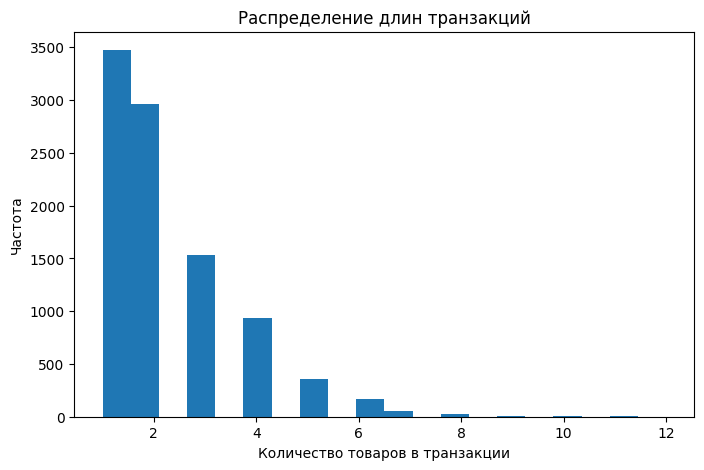

In [64]:
import pandas as pd


df = pd.read_csv("BreadBasket_DMS.csv")
df.info()

unique_items = df['Item'].unique()
len(unique_items)
print("Количество уникальных товаров:", len(unique_items))

transactions = df.groupby('Transaction')['Item'].apply(list)
transactions.head()

transaction_lengths = transactions.apply(len)
transaction_lengths.head()

plt.figure(figsize=(8, 5))
plt.hist(transaction_lengths, bins=20)
plt.xlabel("Количество товаров в транзакции")
plt.ylabel("Частота")
plt.title("Распределение длин транзакций")
plt.show()



Датасет BreadBasket содержит 21 293 записи и 4 признака: дату, время, идентификатор транзакции и наименование товара.
Пропущенные значения в данных отсутствуют.
Каждая строка соответствует одному товару в рамках транзакции, что требует дополнительной агрегации данных по идентификатору транзакции для последующего анализа ассоциативных правил.
Для анализа ассоциативных правил данные были агрегированы по идентификатору транзакции, в результате чего каждая транзакция представляет собой набор товаров, купленных совместно.
Построенный график распределения длин транзакций показывает, что большинство покупок содержит небольшое количество товаров, при этом длинные транзакции встречаются значительно реже.

In [65]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

df_hot = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(
    df_hot,
    min_support=0.02,
    use_colnames=True
)

frequent_itemsets.head()

,support,itemsets
0,0.036093,(Alfajores)
1,0.324940,(Bread)
2,0.039765,(Brownie)
3,0.103137,(Cake)
4,0.475081,(Coffee)


Значение минимальной поддержки было выбрано равным 0.02, что соответствует появлению набора товаров как минимум в 2% транзакций.
При большем значении поддержки теряются потенциально интересные зависимости, а при меньшем — количество правил существенно возрастает, что затрудняет их интерпретацию.
Таким образом, выбранное значение является компромиссом между полнотой и информативностью результатов.

In [66]:
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.4
)

rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()


rules.sort_values(by='lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
8,(Toast),(Coffee),0.033365,0.475081,0.023502,0.704403,1.482699,1.0,0.007651,1.775789,0.336791,0.048464,0.436870,0.376936
4,(Medialuna),(Coffee),0.061379,0.475081,0.034939,0.569231,1.198175,1.0,0.005779,1.218561,0.176213,0.069665,0.179360,0.321387
6,(Pastry),(Coffee),0.085510,0.475081,0.047214,0.552147,1.162216,1.0,0.006590,1.172079,0.152626,0.091968,0.146815,0.325764
3,(Juice),(Coffee),0.038296,0.475081,0.020460,0.534247,1.124537,1.0,0.002266,1.127031,0.115155,0.041507,0.112713,0.288656
5,(NONE),(Coffee),0.079005,0.475081,0.042073,0.532537,1.120938,1.0,0.004539,1.122908,0.117145,0.082172,0.109455,0.310548
7,(Sandwich),(Coffee),0.071346,0.475081,0.037981,0.532353,1.120551,1.0,0.004086,1.122468,0.115847,0.074701,0.109106,0.306150
0,(Cake),(Coffee),0.103137,0.475081,0.054349,0.526958,1.109196,1.0,0.005350,1.109667,0.109767,0.103745,0.098829,0.320679
1,(Cookies),(Coffee),0.054034,0.475081,0.028014,0.518447,1.091280,1.0,0.002343,1.090053,0.088422,0.055905,0.082613,0.288707
2,(Hot chocolate),(Coffee),0.057916,0.475081,0.029378,0.507246,1.067704,1.0,0.001863,1.065276,0.067309,0.058333,0.061276,0.284542


Функция association_rules формирует ассоциативные правила из частых наборов товаров и фильтрует их по заданной метрике.
В данном случае отбираются правила с достоверностью не ниже 0.4, после чего выполняется анализ наиболее значимых правил по значению лифта.

Для выявления наиболее значимых ассоциативных правил была выполнена сортировка по значению лифта.
Это позволило выделить правила, характеризующиеся наиболее сильной связью между товарами и превышающие уровень случайного совпадения.

В результате применения алгоритма Apriori были получены ассоциативные правила, отражающие совместные покупки товаров.
Наиболее значимые правила характеризуются высокой достоверностью и значением лифта больше единицы.
Так, правило «Toast → Coffee» имеет достоверность 0.70 и лифт 1.48, что свидетельствует о сильной зависимости между данными товарами.
Менее значимые правила обладают значением лифта, близким к единице, что указывает на их тривиальность.

In [67]:
supports = [0.01, 0.02, 0.03]
results = {}

for s in supports:
    fi = apriori(df_hot, min_support=s, use_colnames=True)
    results[s] = len(fi)

results

{0.01: 63, 0.02: 36, 0.03: 25}

In [68]:
conf_values = [0.3, 0.5, 0.7]

for c in conf_values:
    r = association_rules(frequent_itemsets, metric="confidence", min_threshold=c)
    print(f"confidence={c}: {len(r)} правил")

confidence=0.3: 11 правил
confidence=0.5: 9 правил
confidence=0.7: 1 правил


В ходе экспериментов было исследовано влияние параметров алгоритма Apriori на результаты анализа.
Уменьшение минимальной поддержки приводит к увеличению количества частых наборов товаров, однако повышает уровень шума в данных.
Увеличение порога достоверности снижает количество ассоциативных правил, оставляя только наиболее надёжные зависимости.
Таким образом, выбор параметров алгоритма является компромиссом между полнотой результатов и их интерпретируемостью.

In [69]:
from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets_fp = fpgrowth(
    df_hot,
    min_support=0.02,
    use_colnames=True
)

frequent_itemsets_fp.head()


,support,itemsets
0,0.324940,(Bread)
1,0.028853,(Scandinavian)
2,0.057916,(Hot chocolate)
3,0.054034,(Cookies)
4,0.038191,(Muffin)


In [70]:
rules_fp = association_rules(
    frequent_itemsets_fp,
    metric="confidence",
    min_threshold=0.4
)

rules_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']] \
    .sort_values(by='lift', ascending=False) \
    .head(10)

,antecedents,consequents,support,confidence,lift
8,(Toast),(Coffee),0.023502,0.704403,1.482699
3,(Medialuna),(Coffee),0.034939,0.569231,1.198175
2,(Pastry),(Coffee),0.047214,0.552147,1.162216
5,(Juice),(Coffee),0.020460,0.534247,1.124537
4,(NONE),(Coffee),0.042073,0.532537,1.120938
7,(Sandwich),(Coffee),0.037981,0.532353,1.120551
6,(Cake),(Coffee),0.054349,0.526958,1.109196
1,(Cookies),(Coffee),0.028014,0.518447,1.091280
0,(Hot chocolate),(Coffee),0.029378,0.507246,1.067704


Для анализа ассоциативных правил был применён алгоритм FP-Growth.
Были получены ассоциативные правила, аналогичные результатам, полученным с помощью алгоритма Apriori.
Наиболее значимые правила характеризуются высокой достоверностью и значением лифта больше единицы, что свидетельствует о наличии устойчивых взаимосвязей между товарами.
Алгоритм FP-Growth показал свою эффективность за счёт отсутствия этапа генерации кандидатов.

| Критерий             | Apriori    | FP-Growth  |
| -------------------- | ---------- | ---------- |
| Генерация кандидатов | Да         | Нет        |
| Скорость             | Ниже       | Выше       |
| Результаты           | Одинаковые | Одинаковые |


In [71]:
support_values = [0.01, 0.02, 0.03]

support_results = []

for s in support_values:
    fi = apriori(df_hot, min_support=s, use_colnames=True)
    rules_s = association_rules(fi, metric="confidence", min_threshold=0.4)
    
    support_results.append({
        'min_support': s,
        'frequent_itemsets': len(fi),
        'rules': len(rules_s)
    })

support_results


[{'min_support': 0.01, 'frequent_itemsets': 63, 'rules': 15},
 {'min_support': 0.02, 'frequent_itemsets': 36, 'rules': 9},
 {'min_support': 0.03, 'frequent_itemsets': 25, 'rules': 5}]

Минимальная поддержка определяет, насколько часто набор товаров должен встречаться в данных, чтобы быть включённым в анализ.

In [72]:
confidence_values = [0.3, 0.5, 0.7]

confidence_results = []

fi_base = apriori(df_hot, min_support=0.02, use_colnames=True)

for c in confidence_values:
    rules_c = association_rules(fi_base, metric="confidence", min_threshold=c)
    
    confidence_results.append({
        'min_confidence': c,
        'rules': len(rules_c)
    })

confidence_results

[{'min_confidence': 0.3, 'rules': 11},
 {'min_confidence': 0.5, 'rules': 9},
 {'min_confidence': 0.7, 'rules': 1}]

При confidence = 0.7 остаётся:

1)только самое надёжное правило
2)остальные отсекаются как менее устойчивые

В ходе экспериментов было исследовано влияние параметров поддержки и достоверности алгоритма Apriori на количество получаемых ассоциативных правил.
Результаты показали, что увеличение минимальной поддержки приводит к уменьшению числа частых наборов и правил, оставляя только наиболее распространённые зависимости.
Увеличение порога достоверности существенно сокращает количество правил, сохраняя лишь наиболее надёжные взаимосвязи.
Таким образом, параметры алгоритма позволяют гибко управлять балансом между количеством и качеством ассоциативных правил, а их выбор зависит от специфики анализируемых данных.

In [73]:
association_rules(fi_base, metric="confidence", min_threshold=0.3) \
    .sort_values(by='lift', ascending=False) \
    .head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
10,(Toast),(Coffee),0.033365,0.475081,0.023502,0.704403,1.482699,1.0,0.007651,1.775789,0.336791,0.048464,0.436870,0.376936
5,(Medialuna),(Coffee),0.061379,0.475081,0.034939,0.569231,1.198175,1.0,0.005779,1.218561,0.176213,0.069665,0.179360,0.321387
7,(Pastry),(Coffee),0.085510,0.475081,0.047214,0.552147,1.162216,1.0,0.006590,1.172079,0.152626,0.091968,0.146815,0.325764


In [74]:
association_rules(fi_base, metric="confidence", min_threshold=0.7) \
    .sort_values(by='lift', ascending=False) \
    .head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Toast),(Coffee),0.033365,0.475081,0.023502,0.704403,1.482699,1.0,0.007651,1.775789,0.336791,0.048464,0.43687,0.376936


Параметр min_threshold задаёт минимальное значение выбранной метрики, при котором ассоциативное правило включается в результат.
В данном случае использовалась метрика достоверности, поэтому min_threshold определяет минимальную допустимую вероятность появления товара в правой части правила при наличии товара в левой части.
Увеличение данного порога приводит к сокращению числа правил и отбору наиболее надёжных зависимостей.

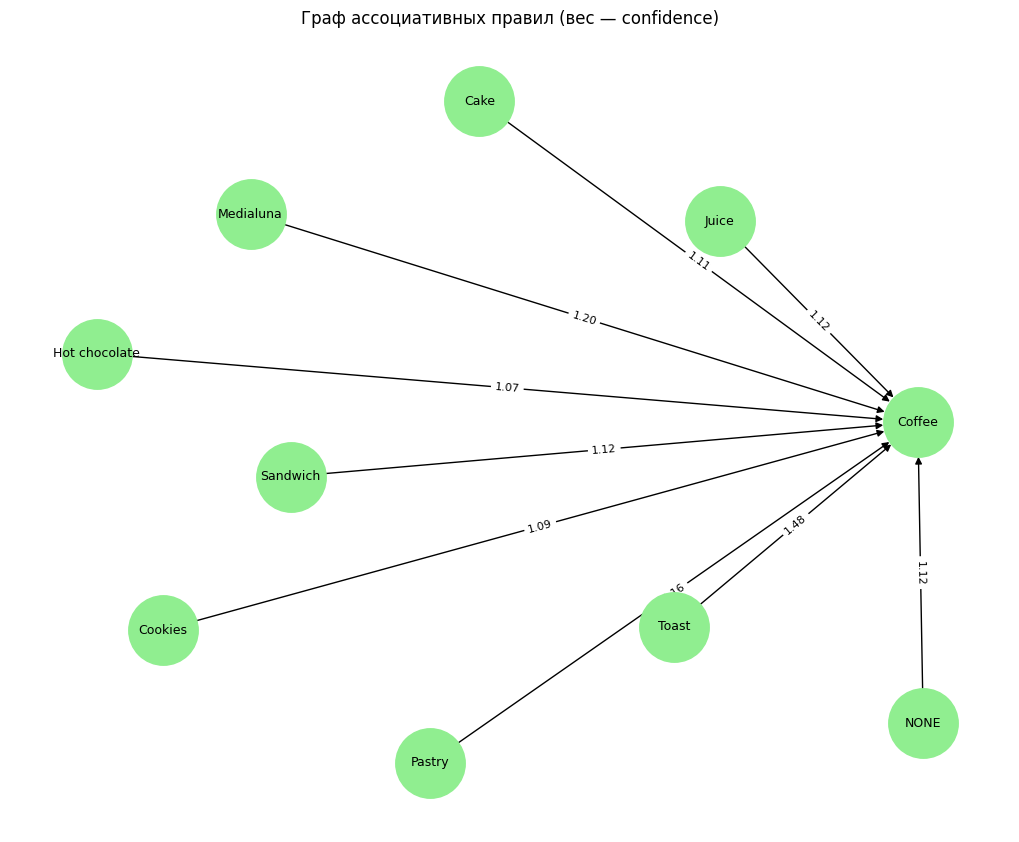

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
rules_graph = rules.copy()

rules_graph['antecedents'] = rules_graph['antecedents'].apply(lambda x: ', '.join(x))
rules_graph['consequents'] = rules_graph['consequents'].apply(lambda x: ', '.join(x))

G = nx.DiGraph()

for _, row in rules_graph.iterrows():
    G.add_node(row['antecedents'])
    G.add_node(row['consequents'])
    
    G.add_edge(
        row['antecedents'],
        row['consequents'],
        weight=row['confidence']
    )


plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G, k=0.8, seed=42)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2500,
    node_color='lightgreen',
    font_size=9,
    arrows=True
)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()},
    font_size=8
)

plt.title("Граф ассоциативных правил (вес — confidence)")
plt.show()



Для наглядного представления ассоциативных правил был построен граф, в котором вершины соответствуют товарам, а рёбра - ассоциативным правилам между ними.
Анализ графа показал, что товар Coffee является центральным элементом, связанным с большинством других товаров, что свидетельствует о его ключевой роли в структуре покупок.
Граф позволяет выявить наиболее сильные зависимости между товарами, а также группы товаров, часто приобретаемых совместно.
Таким образом, графовая визуализация дополняет табличный анализ и облегчает интерпретацию полученных ассоциативных правил.